In [23]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


## Extraemos ejemplo

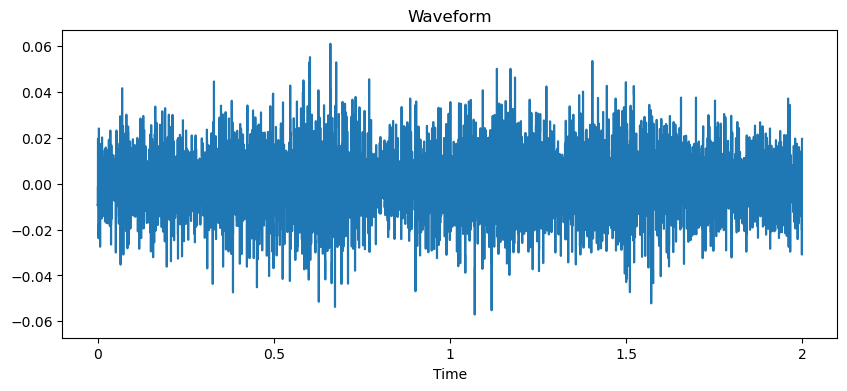

In [7]:

file_path = './data/train/train/1.wav'  
y, sr = librosa.load(file_path, sr=2000)  

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.show()

Audio(data=y, rate=sr)

## Extraccion de carcteristicas

In [24]:
import os
import numpy as np
import pandas as pd

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=2000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    return mfccs_mean

def encode(data_dir, csv_file):
    df = pd.read_csv(os.path.join(data_dir, csv_file))
    data = []
    labels = []
    
    for index, row in df.iterrows():
        file_name = f"train/train/{row['idx']}.wav"
        file_path = os.path.join(data_dir, file_name)
        if os.path.exists(file_path):
            features = extract_features(file_path)
            data.append(features)
            labels.append(1 if row['class'] == 'RightWhale' else 0)
    
    data = np.array(data)
    labels = np.array(labels)
    return data, labels



In [25]:
data_dir = './data'
train_csv = 'train.csv'

x, y = encode(data_dir, train_csv)


### Aplicamos normalizacion

In [26]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

### Aplicamos PCA como reduccion de dimensioalidad

In [27]:
pca = PCA()
pca.fit(x_scaled)

PCA()

Número óptimo de componentes principales: 11


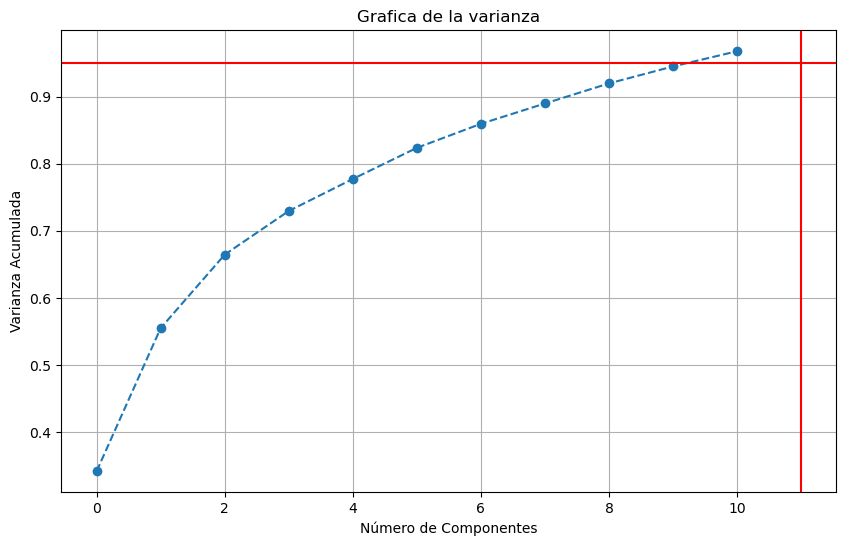

In [31]:

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)


n_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f'Número óptimo de componentes principales: {n_components}')

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=n_components, color='r', linestyle='-')
plt.title('Grafica de la varianza')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.show()

In [29]:
pca = PCA(n_components=n_components)
x_pca = pca.fit_transform(x_scaled)

### Realizamos split para tener train y test

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)


### Prueba de modelo
con reduccion y normalizacion sale mejor

In [32]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)


y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Accuracy: 0.7896662094192959
Precision: 0.7914485165794066
Recall: 0.8040780141843972
F1-Score: 0.7977132805628847
